# Introduction

This example demonstrates using a network pretrained on ImageNet for classification. The model used was converted from the VGG_CNN_S model (http://arxiv.org/abs/1405.3531) in [Caffe's Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo). 

For details of the conversion process, see the example notebook "Using a Caffe Pretrained Network - CIFAR10".

### License
The model is licensed for non-commercial use only

### Download the model (393 MB)

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from utils import load
from scipy.ndimage import imread
import matplotlib.pyplot as plt

first = 64
second = 128
third = 256
fourth = 512

DUMP = "dumps/vgg19.pkl"

Couldn't import dot_parser, loading of dot files will not be possible.


### Define the network

In [5]:
class VGG19(object):

    def __init__(self):
        self.X = T.tensor4('X', 'float64')
        self.output_labels = None
        self.mean_img = None
        self.model = self.build_net(self.X)


    def build_net(self, input_var):
        model = lasagne.layers.InputLayer((None, 3,  224, 224),
                                          input_var=input_var)
        model = lasagne.layers.Conv2DLayer(model, first, 3, pad=1, flip_filters=False)
        model = lasagne.layers.Conv2DLayer(model, first, 3, pad=1, flip_filters=False)
        model = lasagne.layers.MaxPool2DLayer(model, 2)

        model = lasagne.layers.Conv2DLayer(model, second, 3, pad=1, flip_filters=False)
        model = lasagne.layers.Conv2DLayer(model, second, 3, pad=1, flip_filters=False)
        model = lasagne.layers.MaxPool2DLayer(model, 2)

        model = lasagne.layers.Conv2DLayer(model, third, 3, pad=1, flip_filters=False)
        model = lasagne.layers.Conv2DLayer(model, third, 3, pad=1, flip_filters=False)
        model = lasagne.layers.Conv2DLayer(model, third, 3, pad=1, flip_filters=False)
        model = lasagne.layers.Conv2DLayer(model, third, 3, pad=1, flip_filters=False)
        model = lasagne.layers.MaxPool2DLayer(model, 2)

        model = lasagne.layers.Conv2DLayer(model, fourth, 3, pad=1, flip_filters=False)
        model = lasagne.layers.Conv2DLayer(model, fourth, 3, pad=1, flip_filters=False)
        model = lasagne.layers.Conv2DLayer(model, fourth, 3, pad=1, flip_filters=False)
        model = lasagne.layers.Conv2DLayer(model, fourth, 3, pad=1, flip_filters=False)
        model = lasagne.layers.MaxPool2DLayer(model, 2)

        model = lasagne.layers.Conv2DLayer(model, fourth, 3, pad=1, flip_filters=False)
        model = lasagne.layers.Conv2DLayer(model, fourth, 3, pad=1, flip_filters=False)
        model = lasagne.layers.Conv2DLayer(model, fourth, 3, pad=1, flip_filters=False)
        model = lasagne.layers.Conv2DLayer(model, fourth, 3, pad=1, flip_filters=False)
        model = lasagne.layers.MaxPool2DLayer(model, 2)

        model = lasagne.layers.DenseLayer(model, num_units=4096)
        model = lasagne.layers.DropoutLayer(model, p=0.5)
        model = lasagne.layers.DenseLayer(model, num_units=4096)
        model = lasagne.layers.DropoutLayer(model, p=0.5)
        model = lasagne.layers.DenseLayer(model, num_units=1000, nonlinearity=None)
        model = lasagne.layers.NonlinearityLayer(model, lasagne.nonlinearities.softmax)

        lasagne.layers.set_all_param_values(model, self.load_weigths())

        return model

    def load_weigths(self):
        d = load(DUMP)
        self.output_labels = np.array(d['synset words'])
        self.mean_img = d['mean value']
        print "Mean value", self.mean_img
        return d['param values']


    def forward(self, x):
        output = lasagne.layers.get_output(self.model, deterministic=True)
        process = theano.function([self.X], output)
        return process(x)

    def predict(self, x, n=1):
        out = self.forward(x)
        idx = np.argsort(out[0])[-1:-6:-1]
        return self.output_labels[idx]

In [6]:
net = VGG19()

Mean value [ 103.939  116.779  123.68 ]


### Load the model parameters and metadata

In [7]:
CLASSES = net.output_labels
MEAN_IMAGE = net.mean_img

# Trying it out

### Get some test images
We'll download the ILSVRC2012 validation URLs and pick a few at random

In [26]:
import urllib

index = urllib.urlopen('http://www.image-net.org/challenges/LSVRC/2012/ori_urls/indexval.html').read()
image_urls = index.split('<br>')

np.random.seed(23)
np.random.shuffle(image_urls)
image_urls = image_urls[:5]

### Helper to fetch and preprocess images

In [39]:
import io
import skimage.transform
from lasagne.utils import floatX
#import scipy.ndimage as scn
from PIL import Image
import cStringIO

MEAN_IMAGE = MEAN_IMAGE[:, np.newaxis, np.newaxis]

def prep_image(url):
    ext = url.split('.')[-1]
  
    file = cStringIO.StringIO(urllib.urlopen(url).read())
    im = Image.open(file)
    im = np.array(im)
    #im = np.asarray( im.getdata(), dtype='uint8' )
    
    # Resize so smallest dim = 256, preserving aspect ratio
    
    #print "Image", type(im), im.shape
    
    
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (256, w*256/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*256/w, 256), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_IMAGE
    return rawim, floatX(im[np.newaxis])

(333, 500, 3)


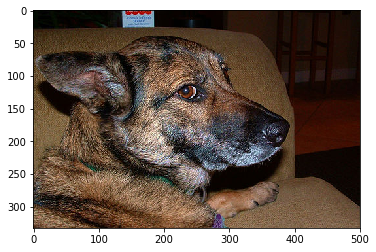

In [40]:
# Test metod do wczytywania obrazu

# ext = url.split('.')[-1]

file = cStringIO.StringIO(urllib.urlopen(url).read())
im = Image.open(file)
im = np.array(im)

print im.shape

plt.imshow(im)

### Process test images and print top 5 predicted labels

Image <type 'numpy.ndarray'> (333, 500, 3)
Image <type 'numpy.ndarray'> (403, 500, 3)
Image <type 'numpy.ndarray'> (333, 500, 3)
Image <type 'numpy.ndarray'> (375, 500, 3)
bad url: http://www.tmk.com/tiger/6F5S5684-l.jpg


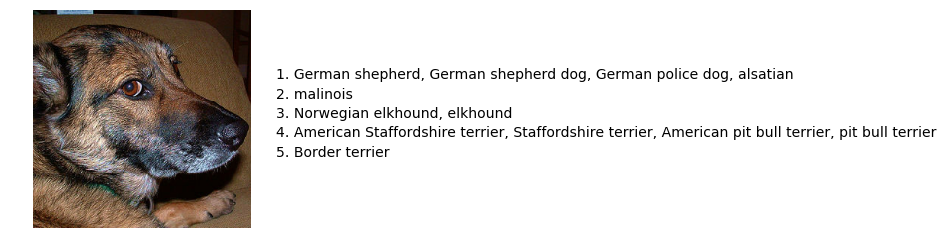

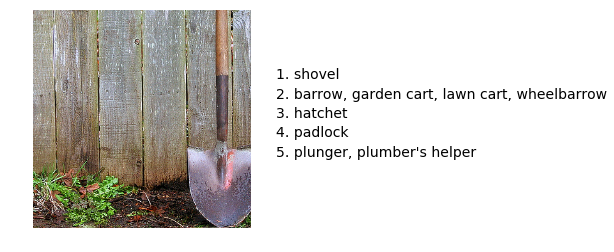

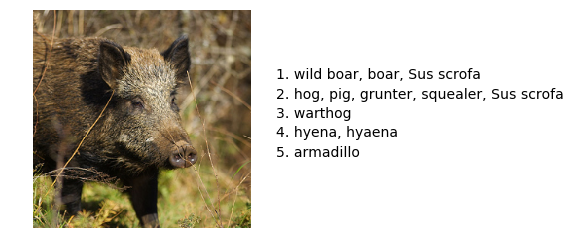

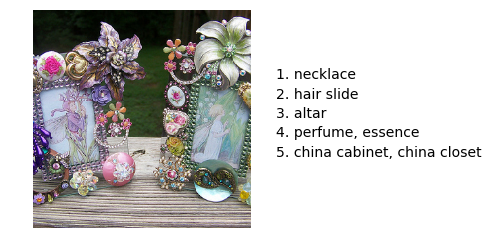

In [42]:
for url in image_urls:
    try:
        #print "Url", url
        rawim, im = prep_image(url)

        prob = net.forward(im)
        top5 = np.argsort(prob[0])[-1:-6:-1]

        plt.figure()
        plt.imshow(rawim.astype('uint8'))
        plt.axis('off')
        for n, label in enumerate(top5):
            plt.text(250, 70 + n * 20, '{}. {}'.format(n+1, CLASSES[label]), fontsize=14)
    except IOError:
        print('bad url: ' + url)

In [50]:
def prep_image_load(path):
    #ext = url.split('.')[-1]
  
    #file = cStringIO.StringIO(urllib.urlopen(url).read())
    im = Image.open(path)
    im = np.array(im)
    #im = np.asarray( im.getdata(), dtype='uint8' )
    
    # Resize so smallest dim = 256, preserving aspect ratio
    
    #print "Image", type(im), im.shape
    
    
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (256, w*256/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*256/w, 256), preserve_range=True)

    # Central crop to 224x224
    h, w, _ = im.shape
    im = im[h//2-112:h//2+112, w//2-112:w//2+112]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    im = im[::-1, :, :]

    im = im - MEAN_IMAGE
    return rawim, floatX(im[np.newaxis])

In [60]:
rawim2, im2 = prep_image_load("dumps/kawa-kopi-luwak-co-to-jest-jak-powstaje.jpg")

TypeError: Invalid dimensions for image data

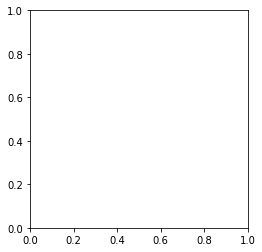

In [61]:
plt.imshow(im2[0])

In [62]:
prob = net.forward(im2)
top5 = np.argsort(prob[0])[-1:-6:-1]

In [63]:
top5

array([967, 968, 504, 828, 960])

In [64]:
for n, label in enumerate(top5):
    print CLASSES[label]

espresso
cup
coffee mug
strainer
chocolate sauce, chocolate syrup
